# Final Project Submission

* Student name: Wendy Jiang
* Student pace: Self Paced 
* Scheduled project review date/time: Tuesday, May 5, 2020 11:30 AM EST
* Instructor name: Jeff Herman
* Blog post URL: https://jwendyjiang.github.io/chasing_the_rabbit


# Import Libraries and Dataset

In [385]:
# import main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import itertools
%matplotlib inline

# import model libraries
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.pipeline import Pipeline

# import other libraries
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score,f1_score,confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

import warnings # ignore warnings
warnings.filterwarnings('ignore')

# fix xgboost error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# get rid of significant figures in floats
pd.options.display.float_format = "{:.2f}".format

In [2]:
df_import = pd.read_csv('data.csv')

# EDA

In [3]:
df_import.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

           ...           RelationshipSatisfaction StandardHours  \
0          ...                                  1            80   
1          ...                                  4            80   
2          ...                                  2            80   
3          ...                                  3            80   
4          ...                                  4            80   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0                 0                  8                      0               1   
1                 1                 10                      3               3   
2                 0                  7                      3               3   
3                 0                  8                      3               3   
4                 1                  6                      3               3   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0               6                  4                        0   
1              10                  7                        1   
2               0                  0                        0   
3               8                  7                        3   
4               2                  2                        2   

   YearsWithCurrManager  
0                     5  
1                     7  
2                     0  
3                     0  
4                     2  

[5 rows x 35 columns]

In [4]:
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [5]:
# quick EDA with pandas_profiling
pdp.ProfileReport(df_import)

In [6]:
# check nulls
df_import.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [7]:
# drop constant fields (StandardHours, EmployeeCount, Over) and unique key identifier (EmployeeNumber) from quick EDA
drop = ['StandardHours', 'EmployeeCount', 'Over18', 'EmployeeNumber']
df = df_import.drop(drop, axis=1)

In [8]:
df.describe().transpose()

count     mean     std     min     25%      50%  \
Age                      1470.00    36.92    9.14   18.00   30.00    36.00   
DailyRate                1470.00   802.49  403.51  102.00  465.00   802.00   
DistanceFromHome         1470.00     9.19    8.11    1.00    2.00     7.00   
Education                1470.00     2.91    1.02    1.00    2.00     3.00   
EnvironmentSatisfaction  1470.00     2.72    1.09    1.00    2.00     3.00   
HourlyRate               1470.00    65.89   20.33   30.00   48.00    66.00   
JobInvolvement           1470.00     2.73    0.71    1.00    2.00     3.00   
JobLevel                 1470.00     2.06    1.11    1.00    1.00     2.00   
JobSatisfaction          1470.00     2.73    1.10    1.00    2.00     3.00   
MonthlyIncome            1470.00  6502.93 4707.96 1009.00 2911.00  4919.00   
MonthlyRate              1470.00 14313.10 7117.79 2094.00 8047.00 14235.50   
NumCompaniesWorked       1470.00     2.69    2.50    0.00    1.00     2.00   
PercentSalaryHike        1470.00    15.21    3.66   11.00   12.00    14.00   
PerformanceRating        1470.00     3.15    0.36    3.00    3.00     3.00   
RelationshipSatisfaction 1470.00     2.71    1.08    1.00    2.00     3.00   
StockOptionLevel         1470.00     0.79    0.85    0.00    0.00     1.00   
TotalWorkingYears        1470.00    11.28    7.78    0.00    6.00    10.00   
TrainingTimesLastYear    1470.00     2.80    1.29    0.00    2.00     3.00   
WorkLifeBalance          1470.00     2.76    0.71    1.00    2.00     3.00   
YearsAtCompany           1470.00     7.01    6.13    0.00    3.00     5.00   
YearsInCurrentRole       1470.00     4.23    3.62    0.00    2.00     3.00   
YearsSinceLastPromotion  1470.00     2.19    3.22    0.00    0.00     1.00   
YearsWithCurrManager     1470.00     4.12    3.57    0.00    2.00     3.00   

                              75%      max  
Age                         43.00    60.00  
DailyRate                 1157.00  1499.00  
DistanceFromHome            14.00    29.00  
Education                    4.00     5.00  
EnvironmentSatisfaction      4.00     4.00  
HourlyRate                  83.75   100.00  
JobInvolvement               3.00     4.00  
JobLevel                     3.00     5.00  
JobSatisfaction              4.00     4.00  
MonthlyIncome             8379.00 19999.00  
MonthlyRate              20461.50 26999.00  
NumCompaniesWorked           4.00     9.00  
PercentSalaryHike           18.00    25.00  
PerformanceRating            3.00     4.00  
RelationshipSatisfaction     4.00     4.00  
StockOptionLevel             1.00     3.00  
TotalWorkingYears           15.00    40.00  
TrainingTimesLastYear        3.00     6.00  
WorkLifeBalance              3.00     4.00  
YearsAtCompany               9.00    40.00  
YearsInCurrentRole           7.00    18.00  
YearsSinceLastPromotion      3.00    15.00  
YearsWithCurrManager         7.00    17.00

## Multicollinearity

From our EDA, we see a couple features that are somewhat correlated.


MonthlyIncome is highly correlated to JobLevel (0.95)
<br>TotalWorkingYears is correlated to JobLevel (0.78)
<br>PerformanceRating is correlated to PercentSalaryHike (0.77)
<br>YearsWithCurrManager is correlated to YearsAtCompany (0.77)
<br>YearsWithCurrManager is correlated to YearsInCurrentRole (0.71)

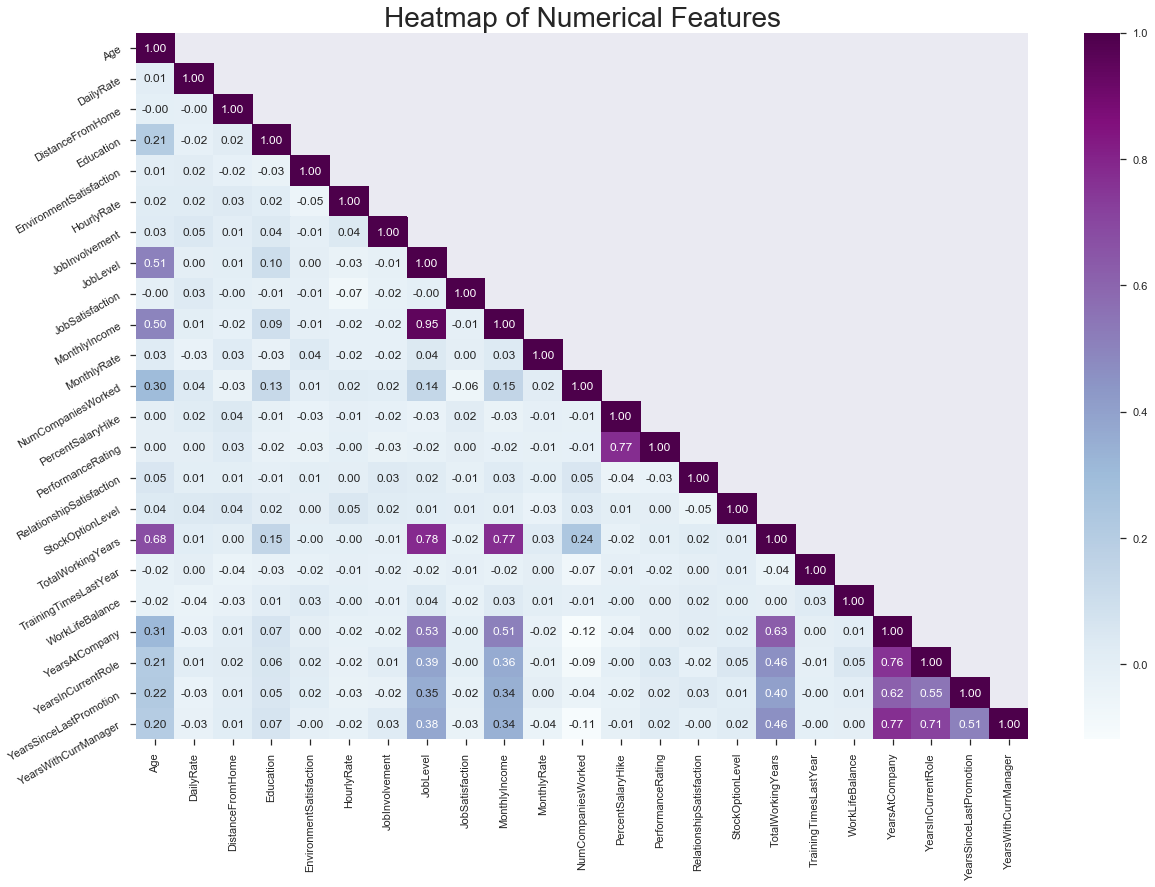

In [9]:
corr = df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(20,13))
# set mast
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
corr_map = sns.heatmap(corr,mask=mask, cmap="BuPu", annot=True, fmt='.2f')
corr_map.set_title("Heatmap of Numerical Features", fontsize=28)
x = corr_map.set_xticklabels(corr_map.get_xticklabels(), rotation=90)
y = corr_map.set_yticklabels(corr_map.get_yticklabels(), rotation=30)

In [10]:
# drop JobLevel
drop_corr = ['JobLevel']
df.drop(drop_corr, axis=1, inplace=True)

In [11]:
# df.drop(drop_multi, axis=1)

## Explore

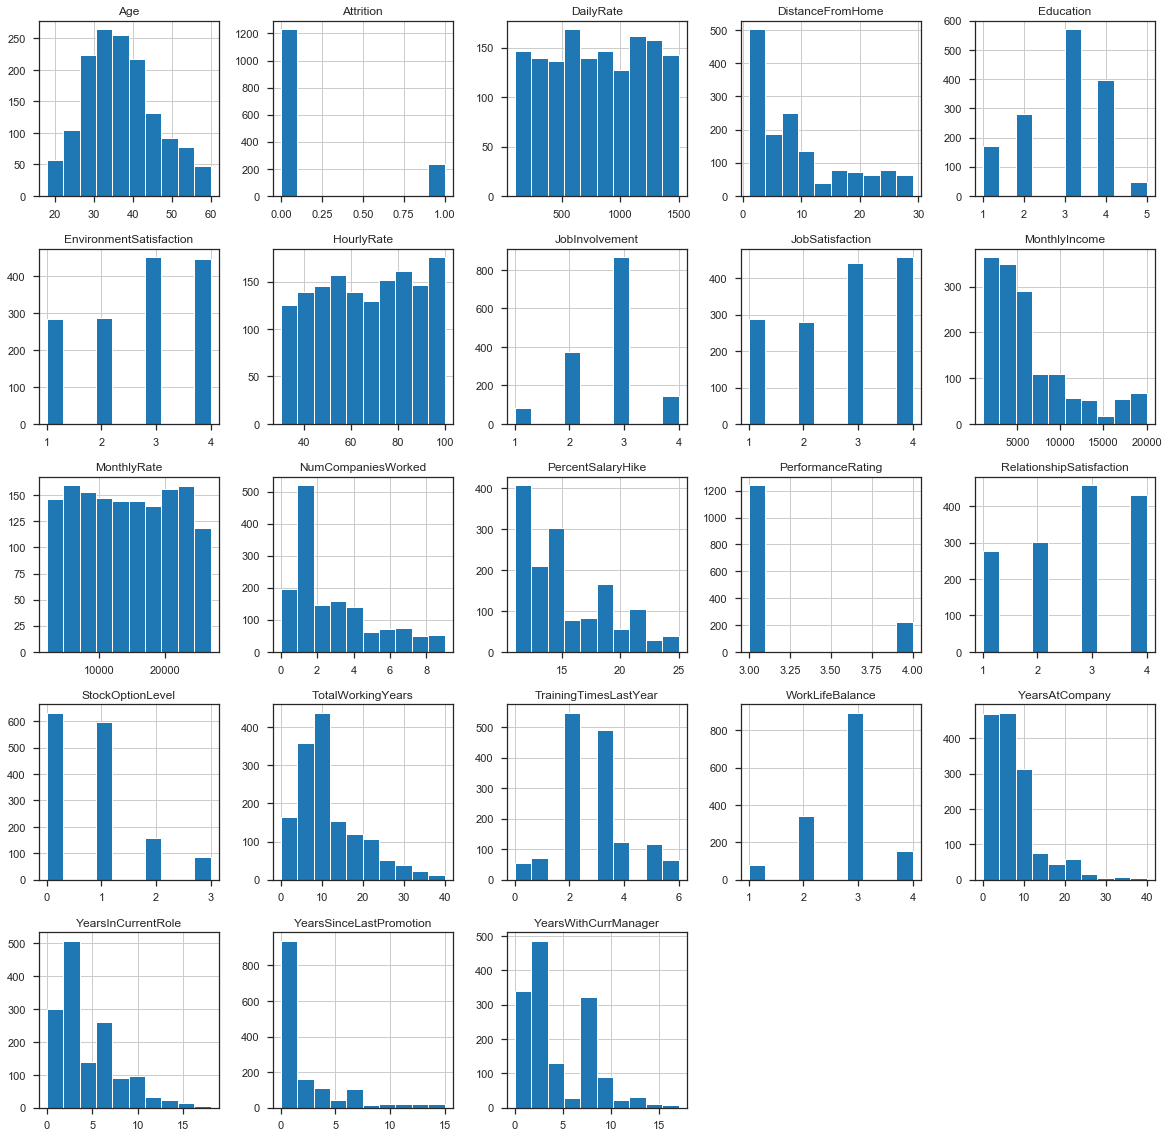

In [172]:
df.hist(figsize=(20,20));

In [173]:
df.Age.describe()

count   1470.00
mean      36.92
std        9.14
min       18.00
25%       30.00
50%       36.00
75%       43.00
max       60.00
Name: Age, dtype: float64

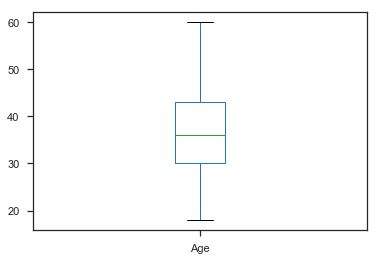

In [174]:
boxplot = df.boxplot(column=['Age'], grid=False, return_type='axes')

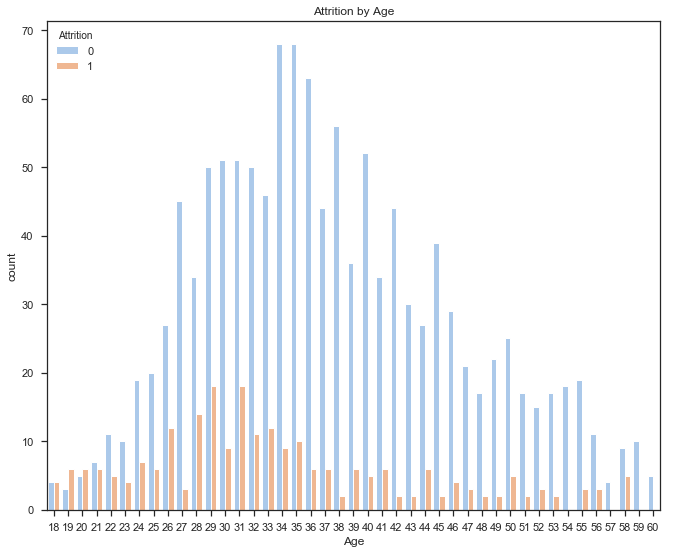

In [175]:
plt.subplots(figsize=(11, 9))
sns.countplot(x=df.Age, hue='Attrition',data=df,palette='pastel')
plt.title('Attrition by Age')
plt.show()

Text(0.5, 1.0, 'Age Distribution by Gender and Marital Status')

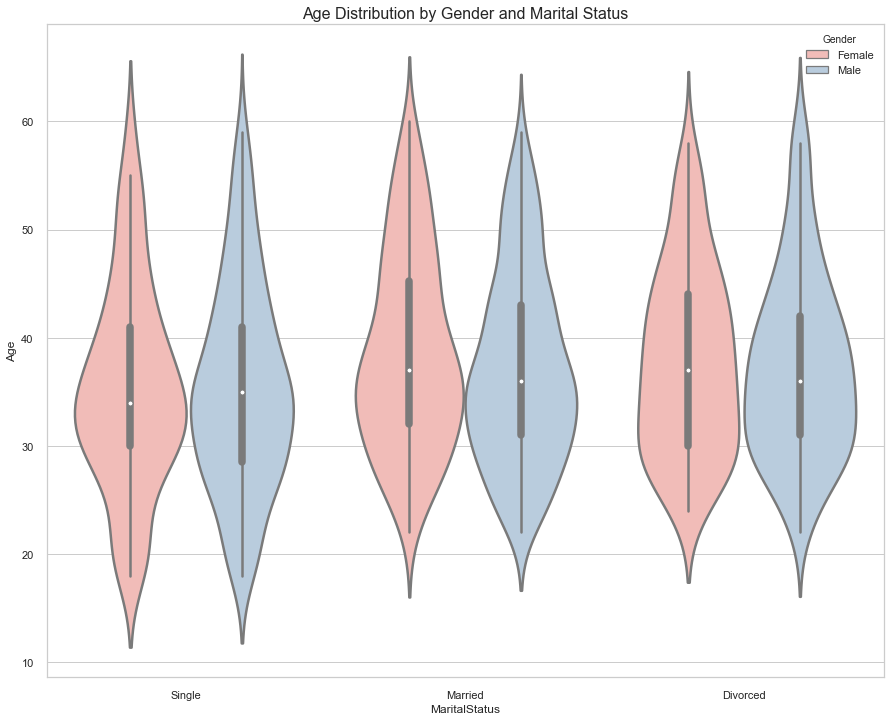

In [176]:
# plot age distribution with a violin plot
plt.figure(figsize = (15, 12))
sns.set_style('whitegrid')
sns.violinplot(x='MaritalStatus', y='Age', hue='Gender', data=df, palette="Pastel1")
plt.title('Age Distribution by Gender and Marital Status', fontsize=16)

Observations: It makes sense that singles trend younger in the workforce, and it's interesting that divorced men are more tightly clustered in their mid-30s, with noticably less older divorced males than females.

# Pre-processing

In [38]:
# Convert to 1, 0 for modeling
df.Attrition.replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True)

In [40]:
df.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [41]:
#create feature dataframe without target
feat = df.drop(['Attrition'],axis=1)
feat.head(3)

Age     BusinessTravel  DailyRate              Department  \
0   41      Travel_Rarely       1102                   Sales   
1   49  Travel_Frequently        279  Research & Development   
2   37      Travel_Rarely       1373  Research & Development   

   DistanceFromHome  Education EducationField  EnvironmentSatisfaction  \
0                 1          2  Life Sciences                        2   
1                 8          1  Life Sciences                        3   
2                 2          2          Other                        4   

   Gender  HourlyRate          ...           PerformanceRating  \
0  Female          94          ...                           3   
1    Male          61          ...                           4   
2    Male          92          ...                           3   

  RelationshipSatisfaction  StockOptionLevel TotalWorkingYears  \
0                        1                 0                 8   
1                        4                 1                10   
2                        2                 0                 7   

   TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany YearsInCurrentRole  \
0                      0                1               6                  4   
1                      3                3              10                  7   
2                      3                3               0                  0   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        1                     7  
2                        0                     0  

[3 rows x 29 columns]

## One-Hot Encode Categorical Features

In [42]:
# one-hot encoding for categorical data
one_hot_feat=pd.get_dummies(feat)
one_hot_feat.head()

Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0   41       1102                 1          2                        2   
1   49        279                 8          1                        3   
2   37       1373                 2          2                        4   
3   33       1392                 3          4                        4   
4   27        591                 2          1                        1   

   HourlyRate  JobInvolvement  JobSatisfaction  MonthlyIncome  MonthlyRate  \
0          94               3                4           5993        19479   
1          61               2                2           5130        24907   
2          92               2                3           2090         2396   
3          56               3                3           2909        23159   
4          40               3                2           3468        16632   

       ...       JobRole_Manufacturing Director  JobRole_Research Director  \
0      ...                                    0                          0   
1      ...                                    0                          0   
2      ...                                    0                          0   
3      ...                                    0                          0   
4      ...                                    0                          0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                           0                        1   
1                           1                        0   
2                           0                        0   
3                           1                        0   
4                           0                        0   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             0                       0   
4                             0                       0   

   MaritalStatus_Married  MaritalStatus_Single  OverTime_No  OverTime_Yes  
0                      0                     1            0             1  
1                      1                     0            1             0  
2                      0                     1            0             1  
3                      1                     0            0             1  
4                      1                     0            1             0  

[5 rows x 50 columns]

In [43]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot_feat)

scaled_feat = pd.DataFrame(scaled_data, columns=one_hot_feat.columns)
scaled_feat.head()

Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0  0.45       0.74             -1.01      -0.89                    -0.66   
1  1.32      -1.30             -0.15      -1.87                     0.25   
2  0.01       1.41             -0.89      -0.89                     1.17   
3 -0.43       1.46             -0.76       1.06                     1.17   
4 -1.09      -0.52             -0.89      -1.87                    -1.58   

   HourlyRate  JobInvolvement  JobSatisfaction  MonthlyIncome  MonthlyRate  \
0        1.38            0.38             1.15          -0.11         0.73   
1       -0.24           -1.03            -0.66          -0.29         1.49   
2        1.28           -1.03             0.25          -0.94        -1.67   
3       -0.49            0.38             0.25          -0.76         1.24   
4       -1.27            0.38            -0.66          -0.64         0.33   

       ...       JobRole_Manufacturing Director  JobRole_Research Director  \
0      ...                                -0.33                      -0.24   
1      ...                                -0.33                      -0.24   
2      ...                                -0.33                      -0.24   
3      ...                                -0.33                      -0.24   
4      ...                                -0.33                      -0.24   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                       -0.50                     1.87   
1                        2.01                    -0.53   
2                       -0.50                    -0.53   
3                        2.01                    -0.53   
4                       -0.50                    -0.53   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                         -0.24                   -0.53   
1                         -0.24                   -0.53   
2                         -0.24                   -0.53   
3                         -0.24                   -0.53   
4                         -0.24                   -0.53   

   MaritalStatus_Married  MaritalStatus_Single  OverTime_No  OverTime_Yes  
0                  -0.92                  1.46        -1.59          1.59  
1                   1.09                 -0.69         0.63         -0.63  
2                  -0.92                  1.46        -1.59          1.59  
3                   1.09                 -0.69        -1.59          1.59  
4                   1.09                 -0.69         0.63         -0.63  

[5 rows x 50 columns]

In [181]:
# create variables
X=scaled_feat
y=df['Attrition']

## Class Imbalance

0    1233
1     237
Name: Attrition, dtype: int64

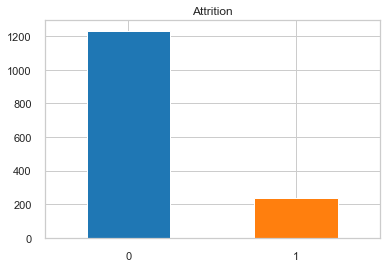

In [49]:
# look at target variable
df['Attrition'].value_counts().plot('bar').set_title('Attrition')
plt.xticks(rotation='horizontal')
df.Attrition.value_counts()

In [204]:
#split data for modeling
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=46)

In [205]:
# SMOTE for class imbalance - training data
from imblearn.over_sampling import SMOTE, ADASYN

# Over sample to acount for class imbalance, check class totals
print(pd.Series(y).value_counts())

X_sampled, y_sampled = SMOTE(random_state=46).fit_sample(X_train,y_train)

print(pd.Series(y_sampled).value_counts())

0    1233
1     237
Name: Attrition, dtype: int64
1    995
0    995
dtype: int64


In [206]:
# add columns back to SMOTE sample
X_sampled = pd.DataFrame(X_sampled, columns = X.columns)
y_sampled = pd.DataFrame(y_sampled)

# Modeling

## Create Baseline Models

In [277]:
# create baseline classifiers for models
clf_dt=tree.DecisionTreeClassifier(random_state=46)
clf_lr=LogisticRegression(random_state=46)
clf_rf=RandomForestClassifier(random_state=46)
clf_svm=svm.SVC(random_state=46)
clf_xgb=xgb.XGBClassifier(random_state=46)

In [278]:
# lists to loop through
classifiers=[clf_xgb,clf_dt,clf_lr,clf_rf,clf_svm]
names=['XGBoost','Decision Tree','Logistic Regression',
       'Random Forest','Support Vector Machine']

In [279]:
# print initial score without tuning & pruning
for i, clf in enumerate(classifiers):
    clf.fit(X_train,y_train)
    # loop to print scores
    print(f'{names[i]} Test Accuracy Score: {clf.score(X_test,y_test):.2%}')
    print(f'{names[i]} F-1 score Score: {f1_score(y_test,clf.predict(X_test)):.2%}')
    
    clf.fit(X_sampled,y_sampled)
    # loop to print scores
    print(f'{names[i]} Test Accuracy Score (with SMOTE): {clf.score(X_test,y_test):.2%}')
    print(f'{names[i]} F-1 score Score (with SMOTE): {f1_score(y_test,clf.predict(X_test)):.2%}')
    print('\n')

XGBoost Test Accuracy Score: 83.67%
XGBoost F-1 score Score: 38.46%
XGBoost Test Accuracy Score (with SMOTE): 85.37%
XGBoost F-1 score Score (with SMOTE): 50.57%


Decision Tree Test Accuracy Score: 78.23%
Decision Tree F-1 score Score: 50.00%
Decision Tree Test Accuracy Score (with SMOTE): 75.51%
Decision Tree F-1 score Score (with SMOTE): 42.86%


Logistic Regression Test Accuracy Score: 89.12%
Logistic Regression F-1 score Score: 66.67%
Logistic Regression Test Accuracy Score (with SMOTE): 73.81%
Logistic Regression F-1 score Score (with SMOTE): 53.89%


Random Forest Test Accuracy Score: 83.33%
Random Forest F-1 score Score: 30.99%
Random Forest Test Accuracy Score (with SMOTE): 80.27%
Random Forest F-1 score Score (with SMOTE): 32.56%


Support Vector Machine Test Accuracy Score: 85.37%
Support Vector Machine F-1 score Score: 42.67%
Support Vector Machine Test Accuracy Score (with SMOTE): 82.65%
Support Vector Machine F-1 score Score (with SMOTE): 51.43%




We will focus more on the F-1 scores with an imbalanced class. Unfortunately, the F-1 scores are pretty bad, even with SMOTE. The general benefits in model improvement with SMOTE is still evident.

## Tuning

### XGBoost

In [383]:
clf_xgb.fit(X_sampled, y_sampled)
training_preds = clf_xgb.predict(X_sampled)
val_preds = clf_xgb.predict(X_test)
val_f1 = f1_score(y_test, val_preds)

print(f'F-1 Score: {val_f1:.2%}')

F-1 Score: 50.57%


In [386]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       238
           1       0.71      0.39      0.51        56

    accuracy                           0.85       294
   macro avg       0.79      0.68      0.71       294
weighted avg       0.84      0.85      0.84       294



In [283]:
clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=46, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [387]:
param_grid_xbg = {
    'learning_rate': [0.1], # default
    'max_depth': [3,4,5,6],
    'n_estimators': [5, 10, 30, 100],
    'subsample': [0.7,1],
    'random_state': [46]
}

In [388]:
# cv None to use the default 5-fold cross validation
grid_clf = GridSearchCV(clf_xgb, param_grid=param_grid_xbg, scoring='f1', cv=None, n_jobs=1)
grid_clf.fit(X_sampled, y_sampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
n_estimators: 30
random_state: 46
subsample: 1


In [389]:
# retrain with chosen values
clf_xgb_tuned = xgb.XGBClassifier(learning_rate= 0.1,
    max_depth= 6,
    n_estimators= 30,
    subsample= 1,
    random_state=46)
clf_xgb_tuned.fit(X_sampled, y_sampled)
training_preds_xgb = clf_xgb_tuned.predict(X_sampled)
val_preds_xgb = clf_xgb_tuned.predict(X_test)
val_f1_xgb = f1_score(y_test, val_preds_xgb)

print(f'F-1 Score: {val_f1_xgb:.2%}')

F-1 Score: 50.00%


In [390]:
print(classification_report(y_test, val_preds_xgb))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       238
           1       0.54      0.46      0.50        56

    accuracy                           0.82       294
   macro avg       0.71      0.69      0.70       294
weighted avg       0.81      0.82      0.82       294



In [287]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,12))
    importances = model.feature_importances_
    index_importance = np.argsort(model.feature_importances_)
    plt.barh(range(n_features), importances[index_importance], align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

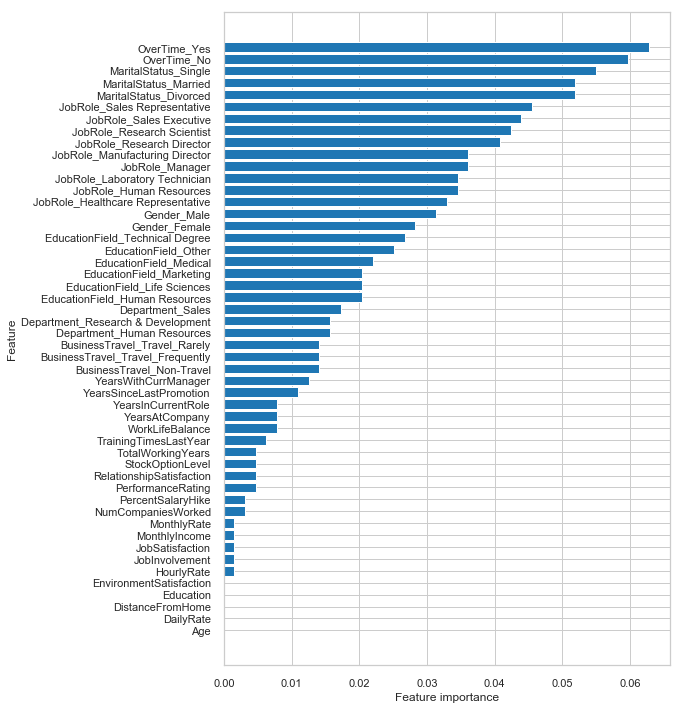

In [288]:
# feature importance of tree-based models
plot_feature_importances(clf_xgb_tuned)

### Decision Tree

In [391]:
# decision tree without SMOTE
clf_dt.fit(X_train, y_train)
training_preds_dt = clf_dt.predict(X_train)
val_preds_dt = clf_dt.predict(X_test)
val_f1_dt = f1_score(y_test, val_preds_dt)

print(f'F-1 Score: {val_f1_dt:.2%}')

F-1 Score: 50.00%


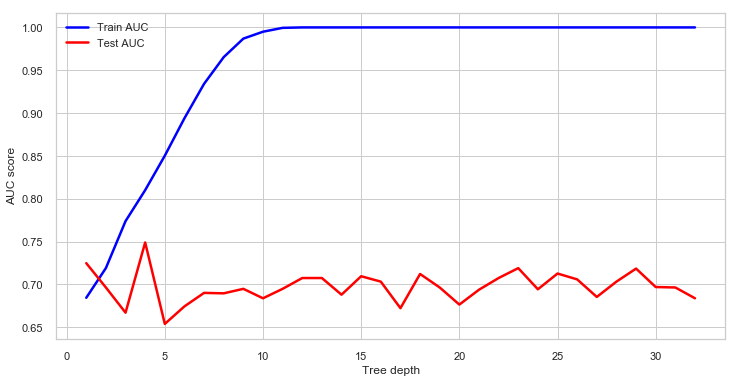

In [290]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
   dt.fit(X_sampled, y_sampled)
   train_pred = dt.predict(X_sampled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_sampled, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [291]:
# training overfit with depth
# test error increases after depth=3
# optimal value seen here around 3

In [292]:
clf_dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=46, splitter='best')

In [393]:
param_grid_dt = {
    'class_weight':  [{0: w, 1: w} for w in [1, 2, 4, 6, 10]],
    'max_depth': [2,3,4,5],
    'max_features': [2,4,6,8,10],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,4]
}

In [394]:
gs_dt = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring='f1', cv=None, n_jobs=1)
gs_dt.fit(scaled_feat, y)

best_parameters = gs_dt.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

val_preds = gs_dt.predict(X_test)
val_f1 = f1_score(y_test, val_preds)

Grid Search found the following optimal parameters: 
class_weight: {0: 1, 1: 1}
max_depth: 4
max_features: 8
min_samples_leaf: 2
min_samples_split: 2


In [395]:
# retrain with chosen values
clf_dt_tuned = DecisionTreeClassifier(class_weight={0:1, 1:1},
    max_depth= 4,
    max_features= 8,
    min_samples_leaf= 2,
    min_samples_split= 2,
    random_state=46)
clf_dt_tuned.fit(X_sampled, y_sampled)

DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='gini', max_depth=4,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=46, splitter='best')

In [396]:
training_preds_dt = clf_dt_tuned.predict(X_sampled)
val_preds_dt = clf_dt_tuned.predict(X_test)
dt_f1 = f1_score(y_test, val_preds_dt)
print(f'F-1 Score: {dt_f1:.2%}')

F-1 Score: 46.81%


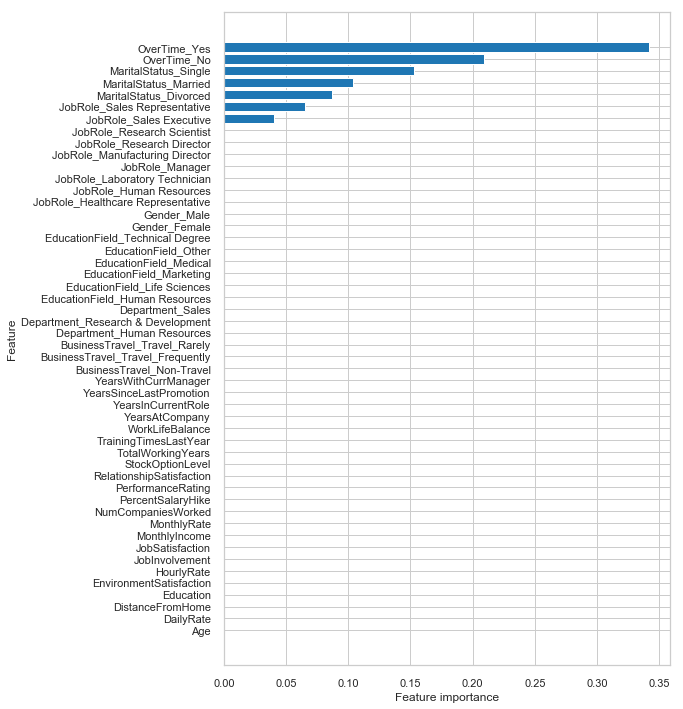

In [319]:
plot_feature_importances(clf_dt_tuned)

# Conclusion

In [320]:
# show scores and confusion matrix
def test_model_performance(y,preds,model):
    print('{} Performance'.format(model))
    print('--------------')
    
    #print accuracy score as percentage
    print('Accuracy: {:.4}%'.format(
        accuracy_score(y,preds) * 100))
    
    # print AUC
    fpr, tpr, thresholds = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    print('AUC is: {:.2}'.format(roc_auc))
    
    # f1_score
    print('F1: {:.4}'.format(f1_score(y,preds)))
    
    # create and plot confusion matrix
    cnf_matrix = confusion_matrix(y,preds)
    plot_confusion_matrix(cnf_matrix)


# plot confusion matrix
def plot_confusion_matrix(cnf_matrix):
    plt.imshow(cnf_matrix,  cmap=plt.cm.coolwarm)
    sns.set_style('ticks')
    
    # labels
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted label')
    class_names = set(y) 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cnf_matrix.max() / 2
    
    # append labels to cm
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
    plt.colorbar()
    plt.show()

XGBoost Training Performance
--------------
Accuracy: 96.28%
AUC is: 0.96
F1: 0.9616


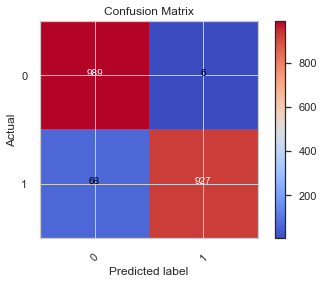

XGBoost Testing Performance
--------------
Accuracy: 85.37%
AUC is: 0.68
F1: 0.5057


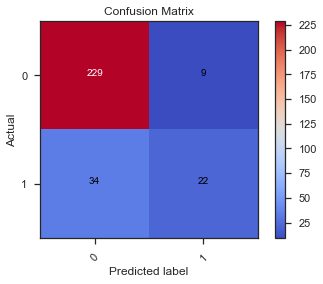

In [354]:
test_model_performance(y_sampled,training_preds_xgb,'XGBoost Training')
test_model_performance(y_test,val_preds_xgb,'XGBoost Testing')

XGBoost Training Performance
--------------
Accuracy: 98.24%
AUC is: 0.98
F1: 0.9822


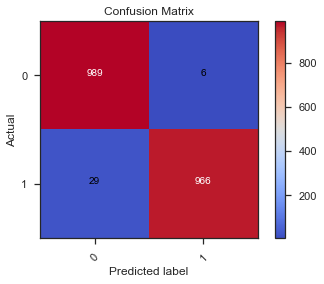

XGBoost Testing Performance
--------------
Accuracy: 82.31%
AUC is: 0.69
F1: 0.5


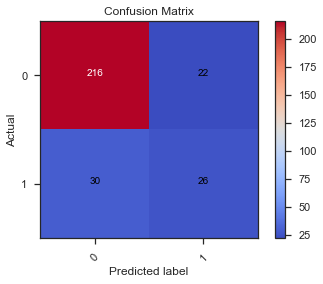

In [397]:
test_model_performance(y_sampled,training_preds_xgb,'XGBoost Training')
test_model_performance(y_test,val_preds_xgb,'XGBoost Testing')